# Importamos las Librerías

In [121]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import seaborn as sns
import re

In [122]:
## Asignamos el estilo para las gráficas posteriores
sns.set(style="whitegrid")

# Funciones

In [123]:
def limpiar_numero(valor):
    """
    Limpia números en formato texto tipo:
    - "3.952.17" -> 3952.17
    - "1,23" -> 1.23
    Devuelve float o NaN si no se puede convertir.
    """
    s = str(valor).strip()
    if s == "" or s.lower() == "nan":
        return np.nan

    ## Tratar comas como separador decimal
    s = s.replace(",", ".")

    ## Si hay más de un punto, dejamos solo el último como decimal
    if s.count(".") > 1:
        last_dot = s.rfind(".")
        parte_entera = s[:last_dot].replace(".", "")
        parte_decimal = s[last_dot + 1 :]
        s = parte_entera + "." + parte_decimal

    try:
        return float(s)
    except ValueError:
        return np.nan

In [124]:
def clasificar_movimiento(fila):
    """
    Clasifica cada fila en:
    - saldo_inicial
    - transferencia
    - gasto
    - ingreso
    - desconocido
    usando la categoría y el signo de amount.
    """
    cat = str(fila.get("category", ""))
    cantidad = fila.get("amount", np.nan)

    ## Saldos iniciales
    if "Initial balance" in cat:
        return "saldo_inicial"

    ## Transferencias entre cuentas
    if cat.startswith("To ") or cat.startswith("From "):
        return "transferencia"

    ## Si no tenemos cantidad, lo marcamos como desconocido
    if pd.isna(cantidad):
        return "desconocido"

    ## Gasto / ingreso según el signo
    if cantidad < 0:
        return "gasto"
    if cantidad > 0:
        return "ingreso"

    return "desconocido"

# Cargar el Dataset

In [125]:
## Mostrar todos los decimales completos
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

df = pd.read_csv('C://Users//mitev//Desktop//Prácticas//MONEFY_PROYECT//datasets//Monefy.Data.20-11-25.csv')

df.head()

,date,account,category,amount,currency,converted amount,currency.1,description
0,11/11/2025,Revolut,Comida,-11.95,EUR,-11.95,EUR,HiperDino
1,11/11/2025,ImaginBank,Compras,-15,EUR,-15,EUR,Belros OpenMall
2,11/11/2025,Efectivo,Initial balance 'Efectivo',203,EUR,203,EUR,NaN
3,11/11/2025,ImaginBank,Initial balance 'ImaginBank',780.01,EUR,780.01,EUR,NaN
4,11/11/2025,Revolut,Initial balance 'Revolut',22.59,EUR,22.59,EUR,NaN


# EDA

In [126]:
df2 = df.copy()

In [127]:
## Convertir columnas numéricas usando limpiar_numero
df2["amount"] = df2["amount"].apply(limpiar_numero)
df2["converted amount"] = df2["converted amount"].apply(limpiar_numero)

In [128]:
## Convertir la fecha a tipo datetime (día/mes/año)
df2["date"] = pd.to_datetime(df2["date"], dayfirst=True, errors="coerce")

In [129]:
## Crear la columna tipo_movimiento usando la función de la celda 2
df2["tipo_movimiento"] = df2.apply(clasificar_movimiento, axis=1)

In [130]:
## Rellenar description nula en saldos iniciales con "Existencias iniciales"
if "description" in df2.columns:
    ## Consideramos nulo tanto NaN como cadenas vacías
    mask_saldo_inicial = df2["tipo_movimiento"] == "saldo_inicial"
    mask_desc_nula = df2["description"].isna() | (df2["description"].astype(str).str.strip() == "")
    df2.loc[mask_saldo_inicial & mask_desc_nula, "description"] = "Existencias iniciales"

In [131]:
## Eliminar la columna de moneda redundante si existe
if "currency.1" in df2.columns:
    df2 = df2.drop(columns=["currency.1"])

In [132]:
## Reordenar columnas para que quede más claro
columnas_orden = [
    "date",
    "account",
    "category",
    "tipo_movimiento",
    "amount",
    "currency",
    "converted amount",
    "description",
]

In [133]:
## Nos quedamos solo con las que existan (por si cambian en el futuro)
columnas_existentes = [c for c in columnas_orden if c in df2.columns]
df2 = df2[columnas_existentes]

In [134]:
df2.head()

,date,account,category,tipo_movimiento,amount,currency,converted amount,description
0,2025-11-11,Revolut,Comida,gasto,-11.95,EUR,-11.95,HiperDino
1,2025-11-11,ImaginBank,Compras,gasto,-15.00,EUR,-15.00,Belros OpenMall
2,2025-11-11,Efectivo,Initial balance 'Efectivo',saldo_inicial,203.00,EUR,203.00,Existencias iniciales
3,2025-11-11,ImaginBank,Initial balance 'ImaginBank',saldo_inicial,780.01,EUR,780.01,Existencias iniciales
4,2025-11-11,Revolut,Initial balance 'Revolut',saldo_inicial,22.59,EUR,22.59,Existencias iniciales


In [135]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              29 non-null     datetime64[ns]
 1   account           29 non-null     object        
 2   category          29 non-null     object        
 3   tipo_movimiento   29 non-null     object        
 4   amount            29 non-null     float64       
 5   currency          29 non-null     object        
 6   converted amount  29 non-null     float64       
 7   description       29 non-null     object        
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 1.9+ KB


In [136]:
df2.isnull().sum()

date                0
account             0
category            0
tipo_movimiento     0
amount              0
currency            0
converted amount    0
description         0
dtype: int64

In [137]:
## Excluir saldos iniciales y transferencias para ver "movimiento real"
df_real = df2[~df2["tipo_movimiento"].isin(["saldo_inicial", "transferencia"])].copy()

print("Tamaño sin saldos iniciales ni transferencias:", df_real.shape)

Tamaño sin saldos iniciales ni transferencias: (14, 8)


In [138]:
## Crear columnas de gasto e ingreso diferenciadas
#   - importe_gasto: valores negativos (gasto), el resto 0
#   - importe_ingreso: valores positivos (ingreso), el resto 0
df_real["importe_gasto"] = df_real["amount"].where(df_real["amount"] < 0, 0)
df_real["importe_ingreso"] = df_real["amount"].where(df_real["amount"] > 0, 0)

In [139]:
## Columnas en valor absoluto para sumar gastos de forma positiva
df_real["gasto_abs"] = df_real["importe_gasto"].abs()
df_real["ingreso_abs"] = df_real["importe_ingreso"]

In [140]:
## Resumen por tipo_movimiento (dentro de este subconjunto)
resumen_tipo = df_real.groupby("tipo_movimiento")["amount"].sum()

print("Resumen por tipo de movimiento (neto):")
print(resumen_tipo)

Resumen por tipo de movimiento (neto):
tipo_movimiento
gasto     -243.59
ingreso      0.14
Name: amount, dtype: float64


In [141]:
## Gastos por categoría
gastos_por_categoria = (
    df_real[df_real["tipo_movimiento"] == "gasto"]
    .groupby("category")
    .agg(
        gasto_total=("gasto_abs", "sum"),
        n_movimientos=("gasto_abs", "count")
    )
    .sort_values("gasto_total", ascending=False)
)

print("\nGastos por categoría:")
print(gastos_por_categoria)


Gastos por categoría:
                gasto_total  n_movimientos
category                                  
Restaurante           71.80              2
Regalos               47.09              1
Relación              38.08              1
Compras               35.00              3
Comida                17.70              2
Suscripciones         16.98              2
Higiene               14.00              1
Estilo de Vida         2.94              1


In [142]:
## Ingresos por categoría (si existen)
ingresos_por_categoria = (
    df_real[df_real["tipo_movimiento"] == "ingreso"]
    .groupby("category")
    .agg(
        ingreso_total=("ingreso_abs", "sum"),
        n_movimientos=("ingreso_abs", "count")
    )
    .sort_values("ingreso_total", ascending=False)
)

print("\nIngresos por categoría:")
print(ingresos_por_categoria)


Ingresos por categoría:
             ingreso_total  n_movimientos
category                                 
Inversiones           0.14              1


In [143]:
## Gastos por cuenta
gastos_por_cuenta = (
    df_real[df_real["tipo_movimiento"] == "gasto"]
    .groupby("account")
    .agg(
        gasto_total=("gasto_abs", "sum"),
        n_movimientos=("gasto_abs", "count")
    )
    .sort_values("gasto_total", ascending=False)
)

print("\nGastos por cuenta:")
print(gastos_por_cuenta)


Gastos por cuenta:
            gasto_total  n_movimientos
account                               
Efectivo          96.55              4
ImaginBank        79.03              4
Revolut           68.01              5


In [144]:
## Resumen diario (neto: ingresos - gastos)
resumen_diario = (
    df_real
    .groupby("date")["amount"]
    .sum()
    .reset_index(name="neto_diario")
)

print("\nResumen diario (neto):")
print(resumen_diario)


Resumen diario (neto):
        date  neto_diario
0 2025-11-11       -26.95
1 2025-11-12       -24.75
2 2025-11-13        -7.93
3 2025-11-16       -55.00
4 2025-11-17       -11.99
5 2025-11-18      -116.97
6 2025-11-19         0.14


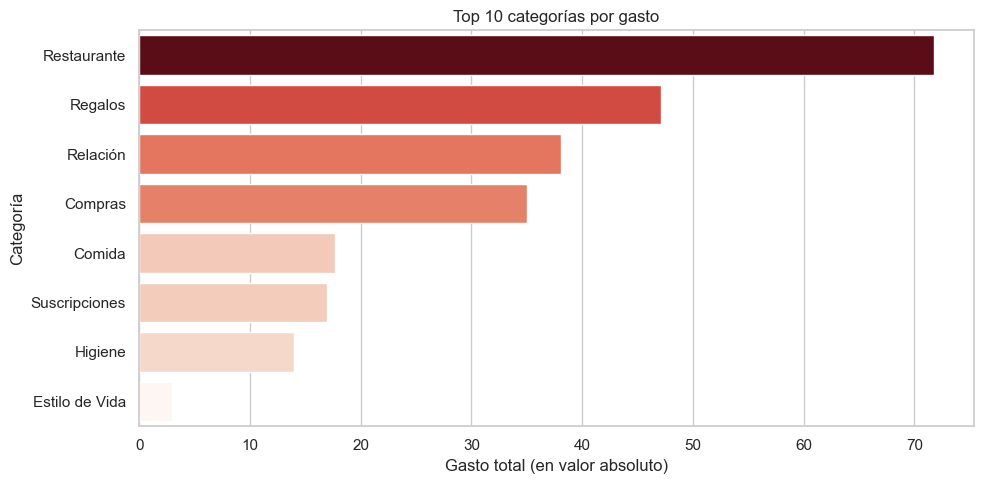

In [145]:
## Gráfico de barras: gastos por categoría (top 10)

gastos_cat_plot = gastos_por_categoria.reset_index().copy()

# Nos quedamos con las 10 categorías con más gasto
top_n = 10
gastos_cat_plot = gastos_cat_plot.head(top_n)

# Normalizar los valores de gasto para mapearlos a un degradado
norm = colors.Normalize(
    vmin=gastos_cat_plot["gasto_total"].min(),
    vmax=gastos_cat_plot["gasto_total"].max()
)
cmap = cm.Reds  # mapa de color en rojos

# Convertimos a lista para que seaborn no se queje
colors_array = cmap(norm(gastos_cat_plot["gasto_total"]))
colors_list = [tuple(c) for c in colors_array]

# Creamos un diccionario categoría -> color
palette_dict = dict(zip(gastos_cat_plot["category"], colors_list))

plt.figure(figsize=(10, 5))
sns.barplot(
    data=gastos_cat_plot,
    x="gasto_total",
    y="category",
    hue="category",           # así contentamos a seaborn
    dodge=False,
    palette=palette_dict,
    legend=False              # ocultamos la leyenda porque no aporta nada
)
plt.title(f"Top {top_n} categorías por gasto")
plt.xlabel("Gasto total (en valor absoluto)")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

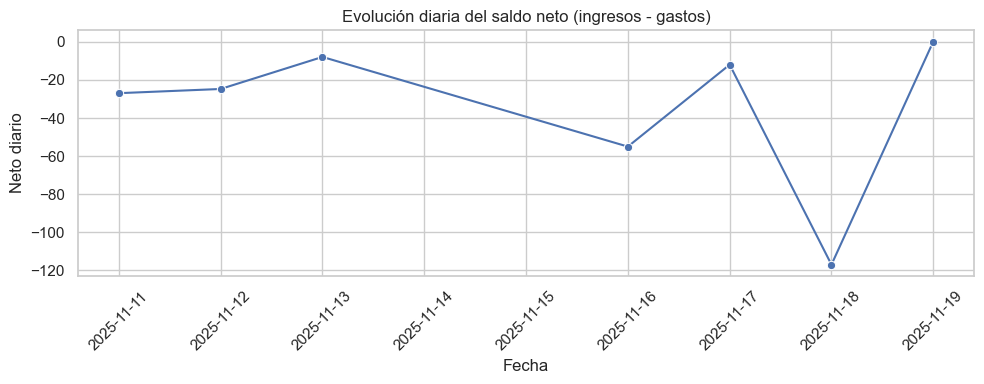

In [146]:
## Gráfico de línea: evolución diaria del neto

plt.figure(figsize=(10, 4))
sns.lineplot(
    data=resumen_diario.sort_values("date"),
    x="date",
    y="neto_diario",
    marker="o"
)
plt.title("Evolución diaria del saldo neto (ingresos - gastos)")
plt.xlabel("Fecha")
plt.ylabel("Neto diario")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [147]:
## Pivot table: neto por cuenta y día (para inspección en tabla)

pivot_cuentas_dia = pd.pivot_table(
    df_real,
    values="amount",
    index="date",
    columns="account",
    aggfunc="sum",
    fill_value=0
)

print("Neto por cuenta y día:")
print(pivot_cuentas_dia)

Neto por cuenta y día:
account     Efectivo  ImaginBank  Revolut
date                                     
2025-11-11      0.00      -15.00   -11.95
2025-11-12    -24.75        0.00     0.00
2025-11-13      0.00       -2.94    -4.99
2025-11-16    -55.00        0.00     0.00
2025-11-17      0.00        0.00   -11.99
2025-11-18    -16.80      -61.09   -39.08
2025-11-19      0.00        0.00     0.14


Gastos por categoría con porcentaje sobre el total (%):
                gasto_total  n_movimientos  porcentaje
category                                              
Restaurante           71.80              2       29.48
Regalos               47.09              1       19.33
Relación              38.08              1       15.63
Compras               35.00              3       14.37
Comida                17.70              2        7.27
Suscripciones         16.98              2        6.97
Higiene               14.00              1        5.75
Estilo de Vida         2.94              1        1.21


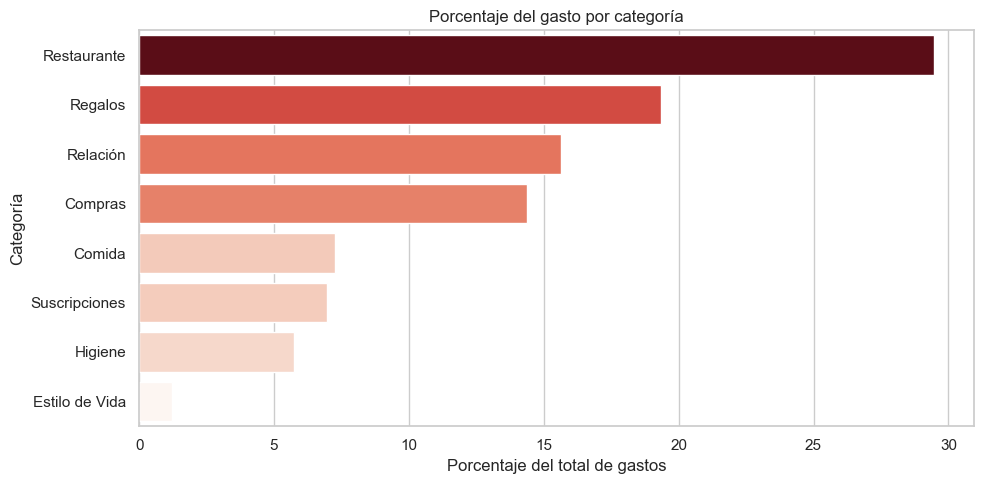

In [148]:
## Porcentaje de gasto por categoría sobre el total de gastos

# Nos aseguramos de usar solo categorías de gasto
gastos_cat_pct = gastos_por_categoria.copy()

total_gasto = gastos_cat_pct["gasto_total"].sum()
gastos_cat_pct["porcentaje"] = gastos_cat_pct["gasto_total"] / total_gasto * 100

print("Gastos por categoría con porcentaje sobre el total (%):")
print(gastos_cat_pct)

# Preparamos datos para el plot
gastos_cat_pct_plot = gastos_cat_pct.reset_index().copy()

# Normalizar los porcentajes para mapearlos a un degradado de rojos
norm = colors.Normalize(
    vmin=gastos_cat_pct_plot["porcentaje"].min(),
    vmax=gastos_cat_pct_plot["porcentaje"].max()
)
cmap = cm.Reds

# Convertimos a lista de colores y construimos un diccionario categoría -> color
colors_array = cmap(norm(gastos_cat_pct_plot["porcentaje"]))
colors_list = [tuple(c) for c in colors_array]
palette_dict = dict(zip(gastos_cat_pct_plot["category"], colors_list))

# Gráfico de barras por porcentaje con degradado rojo
plt.figure(figsize=(10, 5))
sns.barplot(
    data=gastos_cat_pct_plot,
    x="porcentaje",
    y="category",
    hue="category",      # para que acepte el palette
    dodge=False,
    palette=palette_dict,
    legend=False         # no necesitamos leyenda
)
plt.title("Porcentaje del gasto por categoría")
plt.xlabel("Porcentaje del total de gastos")
plt.ylabel("Categoría")
plt.tight_layout()
plt.show()

Neto diario y neto acumulado:
        date  neto_diario  neto_acumulado
0 2025-11-11       -26.95          -26.95
1 2025-11-12       -24.75          -51.70
2 2025-11-13        -7.93          -59.63
3 2025-11-16       -55.00         -114.63
4 2025-11-17       -11.99         -126.62
5 2025-11-18      -116.97         -243.59
6 2025-11-19         0.14         -243.45


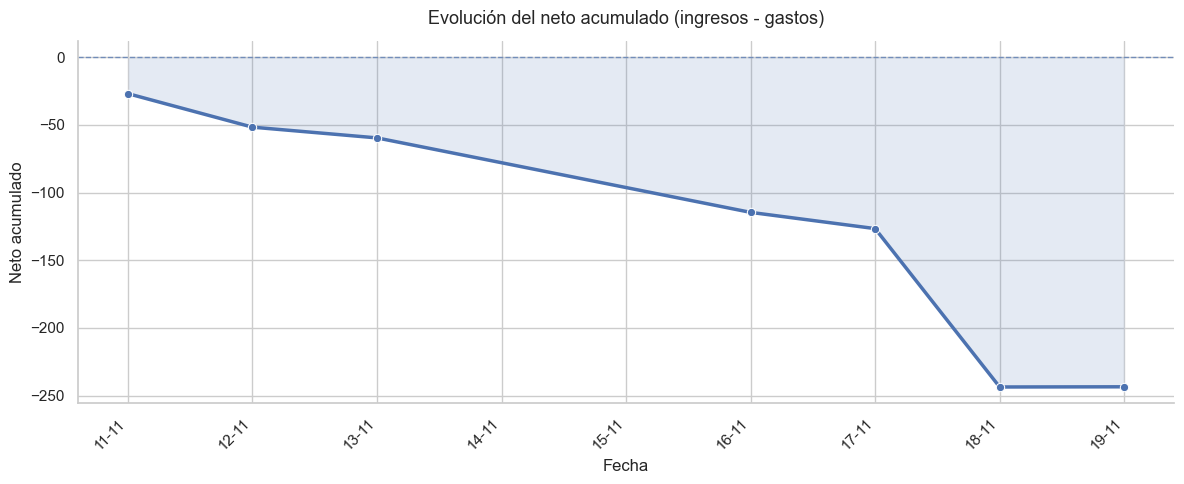

In [149]:
## Evolución del neto acumulado a lo largo del tiempo

resumen_diario_sorted = resumen_diario.sort_values("date").copy()
resumen_diario_sorted["neto_acumulado"] = resumen_diario_sorted["neto_diario"].cumsum()

print("Neto diario y neto acumulado:")
print(resumen_diario_sorted)

fig, ax = plt.subplots(figsize=(12, 5))

# Línea principal
sns.lineplot(
    data=resumen_diario_sorted,
    x="date",
    y="neto_acumulado",
    marker="o",
    linewidth=2.5,
    ax=ax
)

# Relleno suave bajo la curva
ax.fill_between(
    resumen_diario_sorted["date"],
    resumen_diario_sorted["neto_acumulado"],
    alpha=0.15
)

# Línea horizontal en 0 como referencia
ax.axhline(0, linestyle="--", linewidth=1, alpha=0.7)

# Formato bonito de fechas en el eje X
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Títulos y etiquetas
ax.set_title("Evolución del neto acumulado (ingresos - gastos)", fontsize=13, pad=12)
ax.set_xlabel("Fecha")
ax.set_ylabel("Neto acumulado")

# Quitar bordes superiores y derechos para estilo más limpio
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

Tabla neto por cuenta y día:
account     Efectivo  ImaginBank  Revolut
date                                     
2025-11-11      0.00      -15.00   -11.95
2025-11-12    -24.75        0.00     0.00
2025-11-13      0.00       -2.94    -4.99
2025-11-16    -55.00        0.00     0.00
2025-11-17      0.00        0.00   -11.99
2025-11-18    -16.80      -61.09   -39.08
2025-11-19      0.00        0.00     0.14


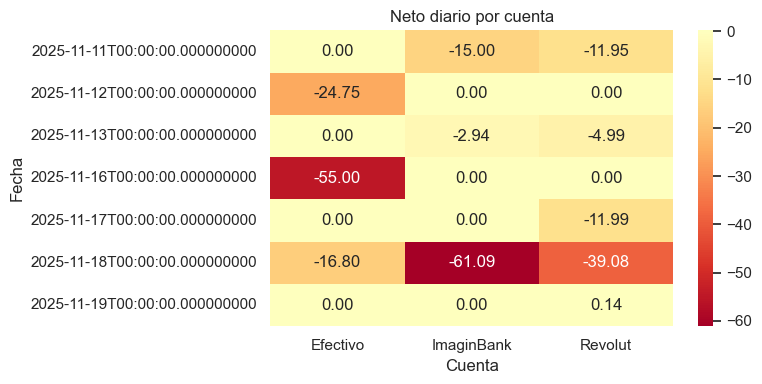

In [150]:
## Mapa de calor del neto (ingresos - gastos) por día y cuenta

pivot_cuentas_dia = pd.pivot_table(
    df_real,
    values="amount",
    index="date",
    columns="account",
    aggfunc="sum",
    fill_value=0
)

print("Tabla neto por cuenta y día:")
print(pivot_cuentas_dia)

plt.figure(figsize=(8, 4))
sns.heatmap(
    pivot_cuentas_dia,
    annot=True,
    fmt=".2f",
    cmap="RdYlGn",
    center=0
)
plt.title("Neto diario por cuenta")
plt.xlabel("Cuenta")
plt.ylabel("Fecha")
plt.tight_layout()
plt.show()